In [1]:
%cd ../..

c:\Users\tacke\OneDrive\Documents\GitHub\Modern-Time-Series-Forecasting-with-Python-2E-1


In [2]:
%load_ext autoreload
%autoreload 2

### Installing NeuralForecast (if not installed)


In [3]:
# %%capture
# !pip install neuralforecast

### Common Imports


In [4]:
import numpy as np
import pandas as pd

### Common Functions and metrics


- The `plot_grid` auxiliary function defined below will be useful to plot different time series, and different models' forecasts.Importing it from `src/utils/plotting_utils.
- `average_length` isn't implemented in `utilsforecast`, and therefore we have implemented it the same way as the rest of the metrics. Importing it from `src/utils/ts_utils.py`.
- `level_to_quantiles` is a function that converts a level to a quantile. Importing it from `src/utils/ts_utils.py`.


In [5]:
from src.utils.ts_utils import average_length, level_to_quantiles
from src.utils.plotting_utils import plot_grid

In [6]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss


def train_LSTM_model(Y_train_df, horizon, **kwargs):
    lstm_config = dict(
        input_size=3 * horizon, encoder_hidden_size=8, decoder_hidden_size=8
    )
    models = [
        LSTM(h=horizon, alias="LSTM", **lstm_config),
    ]
    # Setting freq=1 because the ds column is not date, but instead a sequentially increasing number
    nf = NeuralForecast(models=models, freq=1)
    nf.fit(df=Y_train_df)
    return nf


def train_LSTM_QR_model(Y_train_df, horizon, **kwargs):
    level = kwargs.get("level", [90])
    lstm_config = dict(
        input_size=3 * horizon, encoder_hidden_size=8, decoder_hidden_size=8
    )
    models = [
        LSTM(h=horizon, loss=MQLoss(level=level), alias="LSTM_QR", **lstm_config),
    ]
    # Setting freq=1 because the ds column is not date, but instead a sequentially increasing number
    nf = NeuralForecast(models=models, freq=1)
    nf.fit(df=Y_train_df)
    return nf


def train_LSTM_PDF_model(Y_train_df, horizon, **kwargs):
    level = kwargs.get("level", [90])
    lstm_config = dict(
        input_size=3 * horizon, encoder_hidden_size=8, decoder_hidden_size=8
    )
    models = [
        LSTM(
            h=horizon,
            loss=DistributionLoss(distribution="Normal", level=level),
            alias="LSTM_Normal",
            **lstm_config
        ),
    ]
    # Setting freq=1 because the ds column is not date, but instead a sequentially increasing number
    nf = NeuralForecast(models=models, freq=1)
    nf.fit(df=Y_train_df)
    return nf


def generate_assign_predictions(nf, Y_train_df, Y_calib_df, Y_test_df):
    # Predicting for the next horizon (since calibration dataset is same size as test dataset, we can just call predict)
    Y_hat_calib_df = nf.predict()
    Y_hat_calib_df = Y_hat_calib_df.reset_index()
    # Predicting for the test time
    # combining y_calib to y_train
    needed_cols = ["unique_id","ds","y"]
    comb_df = pd.concat([Y_train_df[needed_cols], Y_calib_df[needed_cols]])
    futr_df = nf.make_future_dataframe(comb_df)
    Y_hat_df = nf.predict(df=comb_df, futr_df=futr_df)
    Y_hat_df = Y_hat_df.reset_index()
    # Merging the predictions back to the test_df
    Y_calib_df = Y_calib_df.merge(Y_hat_calib_df, how="left", on=["unique_id", "ds"])
    # Merging the predictions back to the test_df
    Y_test_df = Y_test_df.merge(Y_hat_df, how="left", on=["unique_id", "ds"])
    return Y_calib_df, Y_test_df


def train_predict_LSTM_model(Y_train_df, Y_calib_df, Y_test_df, **kwargs):
    horizon = len(Y_test_df.ds.unique())  # 48
    nf = train_LSTM_model(Y_train_df=Y_train_df, horizon=horizon, **kwargs)
    Y_calib_df, Y_test_df = generate_assign_predictions(
        nf, Y_train_df=Y_train_df, Y_calib_df=Y_calib_df, Y_test_df=Y_test_df
    )
    return Y_calib_df, Y_test_df


def train_predict_LSTM_QR_model(Y_train_df, Y_calib_df, Y_test_df, **kwargs):
    horizon = len(Y_test_df.ds.unique())  # 48
    nf = train_LSTM_QR_model(Y_train_df=Y_train_df, horizon=horizon, **kwargs)
    Y_calib_df, Y_test_df = generate_assign_predictions(
        nf, Y_train_df=Y_train_df, Y_calib_df=Y_calib_df, Y_test_df=Y_test_df
    )
    return Y_calib_df, Y_test_df


def train_predict_LSTM_PDF_model(Y_train_df, Y_calib_df, Y_test_df, **kwargs):
    horizon = len(Y_test_df.ds.unique())  # 48
    nf = train_LSTM_PDF_model(Y_train_df=Y_train_df, horizon=horizon, **kwargs)
    Y_calib_df, Y_test_df = generate_assign_predictions(
        nf, Y_train_df=Y_train_df, Y_calib_df=Y_calib_df, Y_test_df=Y_test_df
    )
    return Y_calib_df, Y_test_df

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def style_df(res_df):
    # Colormap using the same color scheme
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#8bc34a', '#FFEB33', '#FFB647'])

    # Function to apply color based on distance from 0.90 coverage
    def color_coverage(val):
        ideal = 0.90
        distance = abs(val - ideal)
        norm_distance = min(distance / 0.1, 1.0)  # 0.1 as the max distance considered
        color = cmap(norm_distance)
        return f'background-color: rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3]})'

    # Function to apply color to AvgL columns based on row-wise normalization
    def color_avg_length(val, min_val, max_val):
        norm_value = (val - min_val) / (max_val - min_val) if max_val > min_val else 0
        color = cmap(norm_value)
        return f'background-color: rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3]})'

    # Apply the function row-wise to the AvgL columns
    def apply_row_wise_coloring(row):
        min_val = row.min()
        max_val = row.max()
        return [color_avg_length(val, min_val, max_val) for val in row]
    
    def highlight_best_coverage(s):
        # closes to 0.90 coverage
        s = s.apply(lambda x: abs(x - 0.90))
        is_min = s == s.min()
        return ['font-weight: bold' if v else '' for v in is_min]
    
    def highlight_best_avgL(s):
        is_min = s == s.min()
        return ['font-weight: bold' if v else '' for v in is_min]

    # Applying the styles to the res_df
    styled_df = res_df.style.applymap(color_coverage, subset=[col for col in res_df.columns if '_Cov' in col])
    styled_df = styled_df.apply(apply_row_wise_coloring, subset=[col for col in res_df.columns if '_AvgL' in col], axis=1)
    styled_df = styled_df.apply(highlight_best_coverage, subset=[col for col in res_df.columns if '_Cov' in col], axis=1)
    styled_df = styled_df.apply(highlight_best_avgL, subset=[col for col in res_df.columns if '_AvgL' in col], axis=1)
    
    # Format all columns to two decimal places
    styled_df = styled_df.format(precision=2)
    
    cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
        'props': [('background-color', '#ffffb3')]
    }
    index_names = {
        'selector': '.index_name',
        'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
    }
    headers = {
        'selector': 'th:not(.index_name)',
        'props': 'background-color: #504B43; color: white; font-weight:bold;'
    }
    styled_df = styled_df.set_table_styles([cell_hover, index_names, headers])
    # Display the styled dataframe
    return styled_df


### Loading M4 Data

Let's load the data and pick 8 time series to work with.


In [7]:
from src.utils.general import download_m4_data
import os

if not os.path.exists("data/m4/M4-Hourly.csv"):
    download_m4_data()
Y_train_df = pd.read_csv("data/m4/M4-Hourly.csv")
Y_test_df = pd.read_csv(
    "data/m4/M4-Hourly-test.csv"
)  # .rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long.


In [8]:
# Taking first n_series time series from the dataset
n_series = 8
uids = Y_train_df["unique_id"].unique()[:n_series]
Y_train_df = Y_train_df.query("unique_id in @uids")
Y_test_df = Y_test_df.query("unique_id in @uids")

For Conformal Techniques we need an additional hold-out data called Calibration data.


In [9]:
cal_idx = Y_test_df["ds"].min() - Y_test_df.ds.nunique()
Y_calib_df = Y_train_df.loc[Y_train_df.ds >= cal_idx]
Y_train_df = Y_train_df.loc[Y_train_df.ds < cal_idx]

In [10]:
Y_test_df.ds.nunique(), Y_train_df.ds.nunique(), Y_calib_df.ds.nunique()

(48, 652, 48)

### Model Training and Predictions


In [11]:
level = 90

In [12]:
%%capture
prediction_dict = {
    "LSTM": train_predict_LSTM_model(
        Y_train_df=Y_train_df.copy(),
        Y_calib_df=Y_calib_df.copy(),
        Y_test_df=Y_test_df.copy(),
    ),
    "LSTM_QR": train_predict_LSTM_QR_model(
        Y_train_df=Y_train_df.copy(),
        Y_calib_df=Y_calib_df.copy(),
        Y_test_df=Y_test_df.copy(),
        level=[level],
    ),
    "LSTM_PDF": train_predict_LSTM_PDF_model(
        Y_train_df=Y_train_df.copy(),
        Y_calib_df=Y_calib_df.copy(),
        Y_test_df=Y_test_df.copy(),
        level=[level],
    ),
}

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MAE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 928   
4 | context_adapter | Linear        | 4.3 K 
5 | mlp_decoder     | MLP           | 97    
--------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False

Saving it to a file to avoid retraining the model.

In [13]:
import joblib

joblib.dump(prediction_dict, "data/m4/prediction_dict.joblib")

['data/m4/prediction_dict.joblib']

Loading the model from the file.

In [14]:
import joblib

prediction_dict = joblib.load("data/m4/prediction_dict.joblib")

### Conformal Prediction


In [15]:
from utilsforecast.losses import mae, coverage

In [16]:

res_df = pd.DataFrame(index=Y_test_df["unique_id"].unique())

#### Vanilla Conformal Prediction Intervals


In [17]:
from src.conformal.conformal_predictions import ConformalPrediction

In [18]:
Y_calib_df, Y_test_df = prediction_dict['LSTM']

In [19]:
Y_calib_df.head()

,unique_id,ds,y,LSTM
0,H1,653,664.0,691.200256
1,H1,654,550.0,623.102356
2,H1,655,544.0,564.982361
3,H1,656,505.0,501.950012
4,H1,657,483.0,463.481995


In [20]:
cp = ConformalPrediction(model="LSTM", level=level)
cp.fit(Y_calib_df=Y_calib_df)
Y_test_df_cp = cp.predict(Y_test_df=Y_test_df)

In [21]:
cp.method_name

'Vanilla Conformal Prediction (CP)'

In [22]:
Y_test_df_cp.head()

,unique_id,ds,y,LSTM,LSTM-CP-lo-90,LSTM-CP-hi-90
0,H1,701,619.0,617.860840,544.758484,690.963196
1,H1,702,565.0,554.218079,481.115723,627.320435
2,H1,703,532.0,507.458984,434.356628,580.561340
3,H1,704,495.0,459.940063,386.837708,533.042419
4,H1,705,481.0,435.252075,362.149719,508.354431


In [23]:
model_tag = "LSTM-CP"
res_df = res_df.join(
    coverage(Y_test_df_cp, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_Cov"})
    .set_index("unique_id")
)

res_df = res_df.join(
    average_length(Y_test_df_cp, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_AvgL"})
    .set_index("unique_id")
)
res_df

,LSTM-CP_Cov,LSTM-CP_AvgL
H1,0.958333,146.204712
H10,0.937500,45.091675
H100,0.937500,932.494141
H101,1.000000,846.468750
H102,1.000000,1707.875488
H103,0.958333,18867.640625
H104,0.958333,677.956055
H105,1.000000,1008.705078


#### Conformalized Quantile Regression


In [24]:
Y_calib_df, Y_test_df = prediction_dict['LSTM_QR']

In [25]:
Y_calib_df.head()

,unique_id,ds,y,LSTM_QR-median,LSTM_QR-lo-90,LSTM_QR-hi-90
0,H1,653,664.0,628.370178,331.598419,940.077332
1,H1,654,550.0,629.277161,331.499481,940.034546
2,H1,655,544.0,629.543152,329.312653,941.633789
3,H1,656,505.0,625.028015,327.329376,937.682922
4,H1,657,483.0,624.112244,328.012878,936.343872


In [26]:
from src.conformal.conformal_predictions import ConformalizedQuantileRegression

In [27]:
cp = ConformalizedQuantileRegression(model="LSTM_QR", level=level)
cp.fit(Y_calib_df=Y_calib_df)
Y_test_df_cqr = cp.predict(Y_test_df=Y_test_df)

In [28]:
Y_test_df_cqr.head()

,unique_id,ds,y,LSTM_QR-median,LSTM_QR-lo-90,LSTM_QR-hi-90,LSTM_QR-CQR-lo-90,LSTM_QR-CQR-hi-90
0,H1,701,619.0,640.333069,343.902039,951.781006,365.654480,930.028564
1,H1,702,565.0,641.152039,344.250336,951.429932,366.002777,929.677490
2,H1,703,532.0,641.427612,342.063538,953.041992,363.815979,931.289551
3,H1,704,495.0,636.992920,339.818756,949.252075,361.571198,927.499634
4,H1,705,481.0,635.995361,340.833893,947.667725,362.586334,925.915283


In [29]:
model_tag = "LSTM_QR"
res_df = res_df.join(
    coverage(Y_test_df_cqr, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_Cov"})
    .set_index("unique_id")
)

res_df = res_df.join(
    average_length(Y_test_df_cqr, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_AvgL"})
    .set_index("unique_id")
)

model_tag = "LSTM_QR-CQR"
res_df = res_df.join(
    coverage(Y_test_df_cqr, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_Cov"})
    .set_index("unique_id")
)

res_df = res_df.join(
    average_length(Y_test_df_cqr, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_AvgL"})
    .set_index("unique_id")
)
style_df(res_df)

,LSTM-CP_Cov,LSTM-CP_AvgL,LSTM_QR_Cov,LSTM_QR_AvgL,LSTM_QR-CQR_Cov,LSTM_QR-CQR_AvgL
H1,0.96,146.20,1.00,608.67,1.00,565.17
H10,0.94,45.09,0.96,113.68,0.98,115.47
H100,0.94,932.49,1.00,1385.56,0.96,788.64
H101,1.00,846.47,1.00,800.33,1.00,870.04
H102,1.00,1707.88,0.81,1427.40,1.00,1660.79
H103,0.96,18867.64,0.98,55555.72,1.00,76971.55
H104,0.96,677.96,0.90,1147.57,1.00,1433.95
H105,1.00,1008.71,0.94,1077.12,1.00,1416.34


#### Conformalized PDF


In [30]:
Y_calib_df, Y_test_df = prediction_dict['LSTM_PDF']

Our model generates the prediction intervals. But we need the Standad Deviation which was generated from the underlying odel. We can reverse engineer it from the prediction intervals.

In [31]:
from scipy.stats import norm

def calculate_standard_deviation(upper_bound, point_prediction, confidence_level):
    # Calculate the Z-value (critical value) from the confidence level
    z_value = norm.ppf((1 + confidence_level) / 2)

    # Calculate the standard deviation
    sigma = (upper_bound - point_prediction) / z_value
    
    return sigma

def reverse_engineer_sd(X, model_tag, level):
    X["std"] = calculate_standard_deviation(
        X[f"{model_tag}-hi-{level}"], X[model_tag], level / 100
    )
    return X

In [32]:
Y_calib_df = reverse_engineer_sd(Y_calib_df, "LSTM_Normal", level)
Y_test_df = reverse_engineer_sd(Y_test_df, "LSTM_Normal", level)

In [33]:
from src.conformal.conformal_predictions import ConformalizedUncertaintyEstimates

In [34]:
cp = ConformalizedUncertaintyEstimates(model="LSTM_Normal", uncertainty_model="std", level=level)
cp.fit(Y_calib_df=Y_calib_df)
Y_test_df_pdf = cp.predict(Y_test_df=Y_test_df)

In [35]:
model_tag = "LSTM_Normal"
res_df = res_df.join(
    coverage(Y_test_df_pdf, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_Cov"})
    .set_index("unique_id")
)

res_df = res_df.join(
    average_length(Y_test_df_pdf, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_AvgL"})
    .set_index("unique_id")
)

model_tag = "LSTM_Normal-CUE"
res_df = res_df.join(
    coverage(Y_test_df_pdf, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_Cov"})
    .set_index("unique_id")
)

res_df = res_df.join(
    average_length(Y_test_df_pdf, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_AvgL"})
    .set_index("unique_id")
)
style_df(res_df)

,LSTM-CP_Cov,LSTM-CP_AvgL,LSTM_QR_Cov,LSTM_QR_AvgL,LSTM_QR-CQR_Cov,LSTM_QR-CQR_AvgL,LSTM_Normal_Cov,LSTM_Normal_AvgL,LSTM_Normal-CUE_Cov,LSTM_Normal-CUE_AvgL
H1,0.96,146.20,1.00,608.67,1.00,565.17,1.00,365.03,1.00,190.29
H10,0.94,45.09,0.96,113.68,0.98,115.47,1.00,67.90,0.85,38.01
H100,0.94,932.49,1.00,1385.56,0.96,788.64,0.92,848.78,0.94,1021.82
H101,1.00,846.47,1.00,800.33,1.00,870.04,1.00,515.96,1.00,887.93
H102,1.00,1707.88,0.81,1427.40,1.00,1660.79,0.85,818.46,1.00,1793.08
H103,0.96,18867.64,0.98,55555.72,1.00,76971.55,1.00,32424.82,1.00,29778.38
H104,0.96,677.96,0.90,1147.57,1.00,1433.95,1.00,667.08,1.00,697.53
H105,1.00,1008.71,0.94,1077.12,1.00,1416.34,0.96,612.69,1.00,878.91


### Conformal Prediction under Distribution Shift


#### Weighted Conformal Prediction

----

We can choose any method we saw earlier and convert it into a Weighted Conformal Prediction. Let's take the standard Conformal Prediction (`ConformalPrediction`) and see how we can apply weighted conformal prediction to it.

In [36]:
from src.conformal.conformal_predictions import WeightedConformalPredictor

In [37]:
WeightedConformalPredictor?

Init signature:
WeightedConformalPredictor(
    conformal_predictor: src.conformal.conformal_predictions.ConformalPrediction,
    K: int,
    weight_strategy: str,
    custom_weights: list = None,
    decay_factor: float = 0.5,
)
Docstring:      <no docstring>
Init docstring:
Initialize the weighted predictor.

Parameters:
- conformal_predictor: An instance of a conformal prediction class (e.g., ConformalPrediction).
- K: Size of the sliding window for the most recent scores.
- use_uniform_weights: Boolean to decide if uniform weights should be used.
- custom_weights: User-defined weights (K) for the sliding window.
- decay_factor: If provided, use exponential decay with this factor for weights.
File:           c:\users\tacke\onedrive\documents\github\modern-time-series-forecasting-with-python-2e-1\src\conformal\conformal_predictions.py
Type:           type
Subclasses:     

All we need to do is define a conformal predicton using one of the classes wedefined earlier, decide on a weighing mechanism, and a window size. We can choose weighing function between these:
- `weight_strategy` is the strategy to assign weights to the last K timesteps. It can be one of the following:
    - `uniform` will assign equal weights to the last K timesteps.
    - `decay` will take the last K timesteps and assign weights to them based on a decay factor, such that the latest timestep has the highest weight and the oldest timestep has the lowest weight.
    - `custom` will take the last K timesteps and assign weights to them based on a custom array of weights.
- `decay_factor` is the decay factor to be used in the `decay` strategy.
- `custom_weights` is the custom array of weights to be used in the `custom` strategy.

In [38]:
Y_calib_df, Y_test_df = prediction_dict['LSTM']

In [39]:
cp = ConformalPrediction(model="LSTM", level=level)
weighted_cp = WeightedConformalPredictor(
    conformal_predictor=cp,
    K=50,
    weight_strategy="uniform",
)
weighted_cp.fit(Y_calib_df=Y_calib_df)
Y_test_df_wcp = weighted_cp.predict(Y_test_df=Y_test_df)

In [40]:
weighted_cp.method_name

'Vanilla Conformal Prediction Weighted (CP_Wtd)'

In [41]:
Y_test_df_wcp.head()

,unique_id,ds,y,LSTM,LSTM-CP_Wtd-lo-90,LSTM-CP_Wtd-hi-90
0,H1,701,619.0,617.860840,556.797729,678.923950
1,H1,702,565.0,554.218079,493.154968,615.281189
2,H1,703,532.0,507.458984,446.395874,568.522095
3,H1,704,495.0,459.940063,398.876953,521.003174
4,H1,705,481.0,435.252075,374.188965,496.315186


In [42]:
model_tag = "LSTM-CP_Wtd"
res_df = res_df.join(
    coverage(Y_test_df_wcp, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_Cov"})
    .set_index("unique_id")
)

res_df = res_df.join(
    average_length(Y_test_df_wcp, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_AvgL"})
    .set_index("unique_id")
)
style_df(res_df)

,LSTM-CP_Cov,LSTM-CP_AvgL,LSTM_QR_Cov,LSTM_QR_AvgL,LSTM_QR-CQR_Cov,LSTM_QR-CQR_AvgL,LSTM_Normal_Cov,LSTM_Normal_AvgL,LSTM_Normal-CUE_Cov,LSTM_Normal-CUE_AvgL,LSTM-CP_Wtd_Cov,LSTM-CP_Wtd_AvgL
H1,0.96,146.20,1.00,608.67,1.00,565.17,1.00,365.03,1.00,190.29,0.92,122.13
H10,0.94,45.09,0.96,113.68,0.98,115.47,1.00,67.90,0.85,38.01,0.92,41.27
H100,0.94,932.49,1.00,1385.56,0.96,788.64,0.92,848.78,0.94,1021.82,0.90,691.34
H101,1.00,846.47,1.00,800.33,1.00,870.04,1.00,515.96,1.00,887.93,1.00,746.09
H102,1.00,1707.88,0.81,1427.40,1.00,1660.79,0.85,818.46,1.00,1793.08,1.00,1525.07
H103,0.96,18867.64,0.98,55555.72,1.00,76971.55,1.00,32424.82,1.00,29778.38,0.94,17621.25
H104,0.96,677.96,0.90,1147.57,1.00,1433.95,1.00,667.08,1.00,697.53,0.92,614.72
H105,1.00,1008.71,0.94,1077.12,1.00,1416.34,0.96,612.69,1.00,878.91,1.00,931.20


We have also implemented an online version of the `WeightedConformalPrediction` class, which keeps track of the weights and the window size and updates them as new data comes in. This is more suited to the real online setting of time series data.

In [43]:
from src.conformal.conformal_predictions import OnlineWeightedConformalPredictor

In [44]:
cp = ConformalPrediction(model="LSTM", level=level)
online_weighted_cp = OnlineWeightedConformalPredictor(
    conformal_predictor=cp,
    K=50,
    weight_strategy="uniform",
)
online_weighted_cp.fit(Y_calib_df=Y_calib_df)
Y_test_df_wcpo = online_weighted_cp.offline_predict(Y_test_df=Y_test_df)

In [45]:
Y_test_df_wcpo.head()

,unique_id,ds,y,LSTM,LSTM-CP_Wtd_O-lo-90,LSTM-CP_Wtd_O-hi-90
0,H1,701,619.0,617.860840,556.797729,678.923950
8,H1,702,565.0,554.218079,493.154968,615.281189
16,H1,703,532.0,507.458984,447.288086,567.629883
24,H1,704,495.0,459.940063,399.769165,520.110962
32,H1,705,481.0,435.252075,375.295044,495.209106


**Usage of the `OnlineWeightedConformalPredictor` in a real world online scenario**
```python
# Loading the saved model
online_weighted_cp = joblib.load("saved_model.pkl")
# current timestep data = current, past timestep actuals = last_timestep_actuals
prediction = online_weighted_cp.predict_one(current_test)
# updating the calibration data using the last timestep actuals
online_weighted_cp.update(last_timestep_actuals)
```

In [46]:
model_tag = "LSTM-CP_Wtd_O"
res_df = res_df.join(
    coverage(Y_test_df_wcpo, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_Cov"})
    .set_index("unique_id")
)

res_df = res_df.join(
    average_length(Y_test_df_wcpo, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_AvgL"})
    .set_index("unique_id")
)
style_df(res_df)

,LSTM-CP_Cov,LSTM-CP_AvgL,LSTM_QR_Cov,LSTM_QR_AvgL,LSTM_QR-CQR_Cov,LSTM_QR-CQR_AvgL,LSTM_Normal_Cov,LSTM_Normal_AvgL,LSTM_Normal-CUE_Cov,LSTM_Normal-CUE_AvgL,LSTM-CP_Wtd_Cov,LSTM-CP_Wtd_AvgL,LSTM-CP_Wtd_O_Cov,LSTM-CP_Wtd_O_AvgL
H1,0.96,146.20,1.00,608.67,1.00,565.17,1.00,365.03,1.00,190.29,0.92,122.13,0.92,122.33
H10,0.94,45.09,0.96,113.68,0.98,115.47,1.00,67.90,0.85,38.01,0.92,41.27,0.90,39.93
H100,0.94,932.49,1.00,1385.56,0.96,788.64,0.92,848.78,0.94,1021.82,0.90,691.34,0.92,752.34
H101,1.00,846.47,1.00,800.33,1.00,870.04,1.00,515.96,1.00,887.93,1.00,746.09,0.96,586.47
H102,1.00,1707.88,0.81,1427.40,1.00,1660.79,0.85,818.46,1.00,1793.08,1.00,1525.07,0.98,1213.48
H103,0.96,18867.64,0.98,55555.72,1.00,76971.55,1.00,32424.82,1.00,29778.38,0.94,17621.25,0.83,16595.07
H104,0.96,677.96,0.90,1147.57,1.00,1433.95,1.00,667.08,1.00,697.53,0.92,614.72,0.90,587.65
H105,1.00,1008.71,0.94,1077.12,1.00,1416.34,0.96,612.69,1.00,878.91,1.00,931.20,1.00,801.05


#### Adaptive Conformal Inference

----

We can choose any method we saw earlier and convert it into a AdaptiveConformalInference. Let's take the standard Conformal Prediction (`ConformalPrediction`) and see how we can apply weighted conformal prediction to it. Let's also keep in mind that ACI is a strictly online method.

In [47]:
from src.conformal.conformal_predictions import OnlineAdaptiveConformalInference

In [48]:
OnlineAdaptiveConformalInference?

Init signature:
OnlineAdaptiveConformalInference(
    conformal_predictor: src.conformal.conformal_predictions.ConformalPrediction,
    gamma: float = 0.005,
    update_method: str = 'simple',
    momentum_bw: float = 0.95,
    per_unique_id: bool = True,
)
Docstring:      <no docstring>
Init docstring:
Initialize the Adaptive Conformal Prediction wrapper.

Parameters:
- conformal_predictor: An instance of a conformal prediction class (e.g., ConformalPrediction).
- gamma: Learning rate for updating alpha in the adaptive method.
- update_method: Method for updating alpha ("simple" or "momentum").
- momentum_bw: Bandwidth for the momentum update method.
- per_unique_id: Boolean indicating whether alpha should be maintained separately for each unique_id.
File:           c:\users\tacke\onedrive\documents\github\modern-time-series-forecasting-with-python-2e-1\src\conformal\conformal_predictions.py
Type:           type
Subclasses:     

All we need to do is define a conformal predicton using one of the classes wedefined earlier, decide on a gamma, and the update method. We can choose the update method between these:
- `update_method` is the strategy to update the alpha. It can be one of the following:
    - `simple` will update the alpha based on the last miscoverage rate.
    - `momentum` will update the alpha based on the trajectory of the miscoverage rate.

In [49]:
Y_calib_df, Y_test_df = prediction_dict['LSTM']

In [50]:
cp = ConformalPrediction(model="LSTM", level=level)
aci_cp = OnlineAdaptiveConformalInference(
    conformal_predictor=cp,
    gamma=0.005,
    update_method="simple",
)
aci_cp.fit(Y_calib_df=Y_calib_df)
Y_test_df_aci = aci_cp.offline_predict(Y_test_df=Y_test_df)

In [51]:
Y_test_df_aci.head()

,unique_id,ds,y,LSTM,LSTM-CP_ACI-lo-90,LSTM-CP_ACI-hi-90
0,H1,701,619.0,617.860840,556.797729,678.923950
8,H1,702,565.0,554.218079,493.154968,615.281189
16,H1,703,532.0,507.458984,446.395874,568.522095
24,H1,704,495.0,459.940063,399.769165,520.110962
32,H1,705,481.0,435.252075,375.081177,495.422974


In [52]:
model_tag = "LSTM-CP_ACI"
res_df = res_df.join(
    coverage(Y_test_df_aci, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_Cov"})
    .set_index("unique_id")
)

res_df = res_df.join(
    average_length(Y_test_df_aci, models=[model_tag], level=level)
    .rename(columns={model_tag: f"{model_tag}_AvgL"})
    .set_index("unique_id")
)
style_df(res_df)

,LSTM-CP_Cov,LSTM-CP_AvgL,LSTM_QR_Cov,LSTM_QR_AvgL,LSTM_QR-CQR_Cov,LSTM_QR-CQR_AvgL,LSTM_Normal_Cov,LSTM_Normal_AvgL,LSTM_Normal-CUE_Cov,LSTM_Normal-CUE_AvgL,LSTM-CP_Wtd_Cov,LSTM-CP_Wtd_AvgL,LSTM-CP_Wtd_O_Cov,LSTM-CP_Wtd_O_AvgL,LSTM-CP_ACI_Cov,LSTM-CP_ACI_AvgL
H1,0.96,146.20,1.00,608.67,1.00,565.17,1.00,365.03,1.00,190.29,0.92,122.13,0.92,122.33,0.92,122.98
H10,0.94,45.09,0.96,113.68,0.98,115.47,1.00,67.90,0.85,38.01,0.92,41.27,0.90,39.93,0.90,38.91
H100,0.94,932.49,1.00,1385.56,0.96,788.64,0.92,848.78,0.94,1021.82,0.90,691.34,0.92,752.34,0.90,700.44
H101,1.00,846.47,1.00,800.33,1.00,870.04,1.00,515.96,1.00,887.93,1.00,746.09,0.96,586.47,1.00,675.34
H102,1.00,1707.88,0.81,1427.40,1.00,1660.79,0.85,818.46,1.00,1793.08,1.00,1525.07,0.98,1213.48,0.98,1224.84
H103,0.96,18867.64,0.98,55555.72,1.00,76971.55,1.00,32424.82,1.00,29778.38,0.94,17621.25,0.83,16595.07,0.88,17039.57
H104,0.96,677.96,0.90,1147.57,1.00,1433.95,1.00,667.08,1.00,697.53,0.92,614.72,0.90,587.65,0.90,587.37
H105,1.00,1008.71,0.94,1077.12,1.00,1416.34,0.96,612.69,1.00,878.91,1.00,931.20,1.00,801.05,1.00,858.19


In [53]:
res_df.columns

Index(['LSTM-CP_Cov', 'LSTM-CP_AvgL', 'LSTM_QR_Cov', 'LSTM_QR_AvgL',
       'LSTM_QR-CQR_Cov', 'LSTM_QR-CQR_AvgL', 'LSTM_Normal_Cov',
       'LSTM_Normal_AvgL', 'LSTM_Normal-CUE_Cov', 'LSTM_Normal-CUE_AvgL',
       'LSTM-CP_Wtd_Cov', 'LSTM-CP_Wtd_AvgL', 'LSTM-CP_Wtd_O_Cov',
       'LSTM-CP_Wtd_O_AvgL', 'LSTM-CP_ACI_Cov', 'LSTM-CP_ACI_AvgL'],
      dtype='object')

In [54]:
style_df(res_df[['LSTM_QR_Cov', 'LSTM_QR_AvgL',
       'LSTM_QR-CQR_Cov', 'LSTM_QR-CQR_AvgL']])

,LSTM_QR_Cov,LSTM_QR_AvgL,LSTM_QR-CQR_Cov,LSTM_QR-CQR_AvgL
H1,1.00,608.67,1.00,565.17
H10,0.96,113.68,0.98,115.47
H100,1.00,1385.56,0.96,788.64
H101,1.00,800.33,1.00,870.04
H102,0.81,1427.40,1.00,1660.79
H103,0.98,55555.72,1.00,76971.55
H104,0.90,1147.57,1.00,1433.95
H105,0.94,1077.12,1.00,1416.34


In [55]:
style_df(res_df[['LSTM_Normal_Cov',
       'LSTM_Normal_AvgL', 'LSTM_Normal-CUE_Cov', 'LSTM_Normal-CUE_AvgL']])

,LSTM_Normal_Cov,LSTM_Normal_AvgL,LSTM_Normal-CUE_Cov,LSTM_Normal-CUE_AvgL
H1,1.00,365.03,1.00,190.29
H10,1.00,67.90,0.85,38.01
H100,0.92,848.78,0.94,1021.82
H101,1.00,515.96,1.00,887.93
H102,0.85,818.46,1.00,1793.08
H103,1.00,32424.82,1.00,29778.38
H104,1.00,667.08,1.00,697.53
H105,0.96,612.69,1.00,878.91


In [56]:
style_df(res_df[['LSTM-CP_Cov', 'LSTM-CP_AvgL', 'LSTM-CP_Wtd_Cov', 'LSTM-CP_Wtd_AvgL', 'LSTM-CP_Wtd_O_Cov',
       'LSTM-CP_Wtd_O_AvgL', 'LSTM-CP_ACI_Cov', 'LSTM-CP_ACI_AvgL']])

,LSTM-CP_Cov,LSTM-CP_AvgL,LSTM-CP_Wtd_Cov,LSTM-CP_Wtd_AvgL,LSTM-CP_Wtd_O_Cov,LSTM-CP_Wtd_O_AvgL,LSTM-CP_ACI_Cov,LSTM-CP_ACI_AvgL
H1,0.96,146.20,0.92,122.13,0.92,122.33,0.92,122.98
H10,0.94,45.09,0.92,41.27,0.90,39.93,0.90,38.91
H100,0.94,932.49,0.90,691.34,0.92,752.34,0.90,700.44
H101,1.00,846.47,1.00,746.09,0.96,586.47,1.00,675.34
H102,1.00,1707.88,1.00,1525.07,0.98,1213.48,0.98,1224.84
H103,0.96,18867.64,0.94,17621.25,0.83,16595.07,0.88,17039.57
H104,0.96,677.96,0.92,614.72,0.90,587.65,0.90,587.37
H105,1.00,1008.71,1.00,931.20,1.00,801.05,1.00,858.19


In [57]:
styled_df = style_df(res_df)
styled_df = styled_df.set_properties(**{'width': '50px'})
styled_df

,LSTM-CP_Cov,LSTM-CP_AvgL,LSTM_QR_Cov,LSTM_QR_AvgL,LSTM_QR-CQR_Cov,LSTM_QR-CQR_AvgL,LSTM_Normal_Cov,LSTM_Normal_AvgL,LSTM_Normal-CUE_Cov,LSTM_Normal-CUE_AvgL,LSTM-CP_Wtd_Cov,LSTM-CP_Wtd_AvgL,LSTM-CP_Wtd_O_Cov,LSTM-CP_Wtd_O_AvgL,LSTM-CP_ACI_Cov,LSTM-CP_ACI_AvgL
H1,0.96,146.20,1.00,608.67,1.00,565.17,1.00,365.03,1.00,190.29,0.92,122.13,0.92,122.33,0.92,122.98
H10,0.94,45.09,0.96,113.68,0.98,115.47,1.00,67.90,0.85,38.01,0.92,41.27,0.90,39.93,0.90,38.91
H100,0.94,932.49,1.00,1385.56,0.96,788.64,0.92,848.78,0.94,1021.82,0.90,691.34,0.92,752.34,0.90,700.44
H101,1.00,846.47,1.00,800.33,1.00,870.04,1.00,515.96,1.00,887.93,1.00,746.09,0.96,586.47,1.00,675.34
H102,1.00,1707.88,0.81,1427.40,1.00,1660.79,0.85,818.46,1.00,1793.08,1.00,1525.07,0.98,1213.48,0.98,1224.84
H103,0.96,18867.64,0.98,55555.72,1.00,76971.55,1.00,32424.82,1.00,29778.38,0.94,17621.25,0.83,16595.07,0.88,17039.57
H104,0.96,677.96,0.90,1147.57,1.00,1433.95,1.00,667.08,1.00,697.53,0.92,614.72,0.90,587.65,0.90,587.37
H105,1.00,1008.71,0.94,1077.12,1.00,1416.34,0.96,612.69,1.00,878.91,1.00,931.20,1.00,801.05,1.00,858.19


In [58]:
styled_df = style_df(res_df.loc[:,[c for c in res_df.columns if "Cov" in c]])
styled_df = styled_df.set_properties(**{'width': '50px'})
styled_df


,LSTM-CP_Cov,LSTM_QR_Cov,LSTM_QR-CQR_Cov,LSTM_Normal_Cov,LSTM_Normal-CUE_Cov,LSTM-CP_Wtd_Cov,LSTM-CP_Wtd_O_Cov,LSTM-CP_ACI_Cov
H1,0.96,1.00,1.00,1.00,1.00,0.92,0.92,0.92
H10,0.94,0.96,0.98,1.00,0.85,0.92,0.90,0.90
H100,0.94,1.00,0.96,0.92,0.94,0.90,0.92,0.90
H101,1.00,1.00,1.00,1.00,1.00,1.00,0.96,1.00
H102,1.00,0.81,1.00,0.85,1.00,1.00,0.98,0.98
H103,0.96,0.98,1.00,1.00,1.00,0.94,0.83,0.88
H104,0.96,0.90,1.00,1.00,1.00,0.92,0.90,0.90
H105,1.00,0.94,1.00,0.96,1.00,1.00,1.00,1.00


In [59]:
styled_df = style_df(res_df.loc[:,[c for c in res_df.columns if "AvgL" in c]])
styled_df = styled_df.set_properties(**{'width': '50px'})
styled_df

,LSTM-CP_AvgL,LSTM_QR_AvgL,LSTM_QR-CQR_AvgL,LSTM_Normal_AvgL,LSTM_Normal-CUE_AvgL,LSTM-CP_Wtd_AvgL,LSTM-CP_Wtd_O_AvgL,LSTM-CP_ACI_AvgL
H1,146.20,608.67,565.17,365.03,190.29,122.13,122.33,122.98
H10,45.09,113.68,115.47,67.90,38.01,41.27,39.93,38.91
H100,932.49,1385.56,788.64,848.78,1021.82,691.34,752.34,700.44
H101,846.47,800.33,870.04,515.96,887.93,746.09,586.47,675.34
H102,1707.88,1427.40,1660.79,818.46,1793.08,1525.07,1213.48,1224.84
H103,18867.64,55555.72,76971.55,32424.82,29778.38,17621.25,16595.07,17039.57
H104,677.96,1147.57,1433.95,667.08,697.53,614.72,587.65,587.37
H105,1008.71,1077.12,1416.34,612.69,878.91,931.20,801.05,858.19


### Summary Visualizations

#### Single Bubble Plot for all methods and Unique Time Series

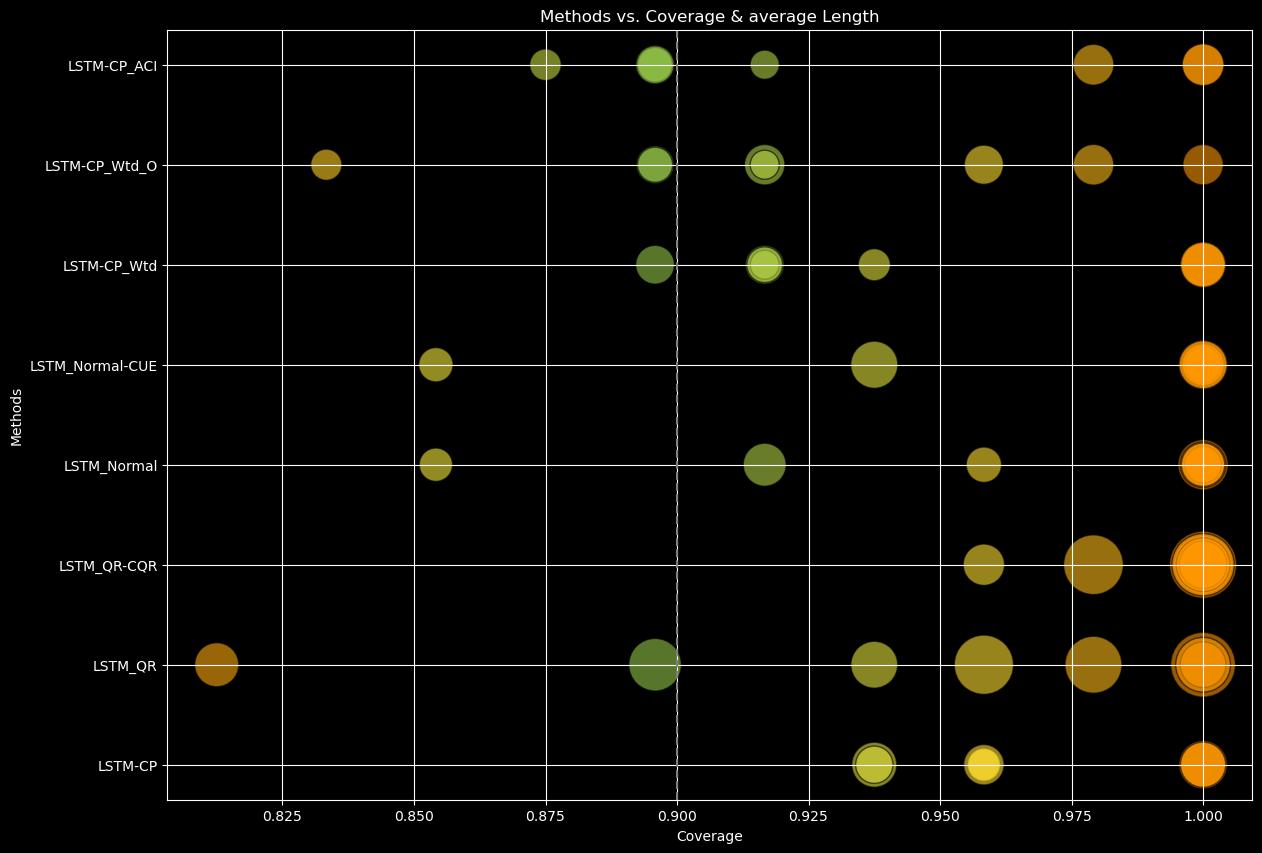

In [60]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Desired order of methods
method_order = ['LSTM-CP', 'LSTM_QR', 'LSTM_QR-CQR', 'LSTM_Normal', 'LSTM_Normal-CUE', 'LSTM-CP_Wtd', 'LSTM-CP_Wtd_O', 'LSTM-CP_ACI']

# Define the colormap using the same color scheme as before
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#8bc34a', '#ffeb3b', '#ff9800'])

# Melt the DataFrame to long format
df_long = pd.melt(res_df.reset_index(), id_vars='index', 
                  value_vars=[f'{method}_Cov' for method in ['LSTM-CP', 'LSTM_QR', 'LSTM_QR-CQR', 'LSTM_Normal', 'LSTM_Normal-CUE', 'LSTM-CP_Wtd', 'LSTM-CP_Wtd_O', 'LSTM-CP_ACI']] + 
                             [f'{method}_AvgL' for method in ['LSTM-CP', 'LSTM_QR', 'LSTM_QR-CQR', 'LSTM_Normal', 'LSTM_Normal-CUE', 'LSTM-CP_Wtd', 'LSTM-CP_Wtd_O', 'LSTM-CP_ACI']],
                  var_name='Metric', value_name='Value')

# Split the 'Metric' column into 'Method' and 'MetricType' (Cov or AvgL)
df_long[['Method', 'MetricType']] = df_long['Metric'].str.rsplit('_', n=1, expand=True)

# Pivot the DataFrame to have separate columns for Coverage and AvgLength
df_pivot = df_long.pivot_table(index=['index', 'Method'], columns='MetricType', values='Value').reset_index()

# Normalize the coverage and average length values for each H value
df_pivot['NormalizedCoverage'] = df_pivot.groupby('index')['Cov'].transform(lambda x: x/x.mean())
df_pivot['NormalizedAvgLength'] = df_pivot.groupby('index')['AvgL'].transform(lambda x: x/x.mean())

# Calculate the color based on the distance from 0.90 coverage
df_pivot['Color'] = df_pivot['Cov'].apply(lambda x: cmap(np.abs(x - 0.90) / 0.1))

df_pivot['Method'] = pd.Categorical(df_pivot['Method'], categories=method_order, ordered=True)

# Sort the dataframe by 'Method' to ensure the plotting order is correct
df_pivot = df_pivot.sort_values('Method')

# Create the bubble plot with swapped axes
plt.figure(figsize=(14, 10))

scatter = plt.scatter(df_pivot['Cov'], df_pivot['Method'], 
                      s=df_pivot['NormalizedAvgLength'] * 1000, 
                      c=df_pivot['Color'], 
                      alpha=0.6, edgecolor='black')

# Customize the plot
plt.yticks(rotation=0)  # Keep method names readable
plt.ylabel('Methods')
plt.xlabel('Coverage')
plt.title('Methods vs. Coverage & average Length')
plt.axvline(0.90, color='grey', linestyle='--', label='Ideal Coverage (0.90)')
# plt.colorbar(scatter, label='Distance from 0.90 Coverage')
plt.grid(True)

# Show the plot
plt.show()


#### Unique Time Series Subplots for all methods

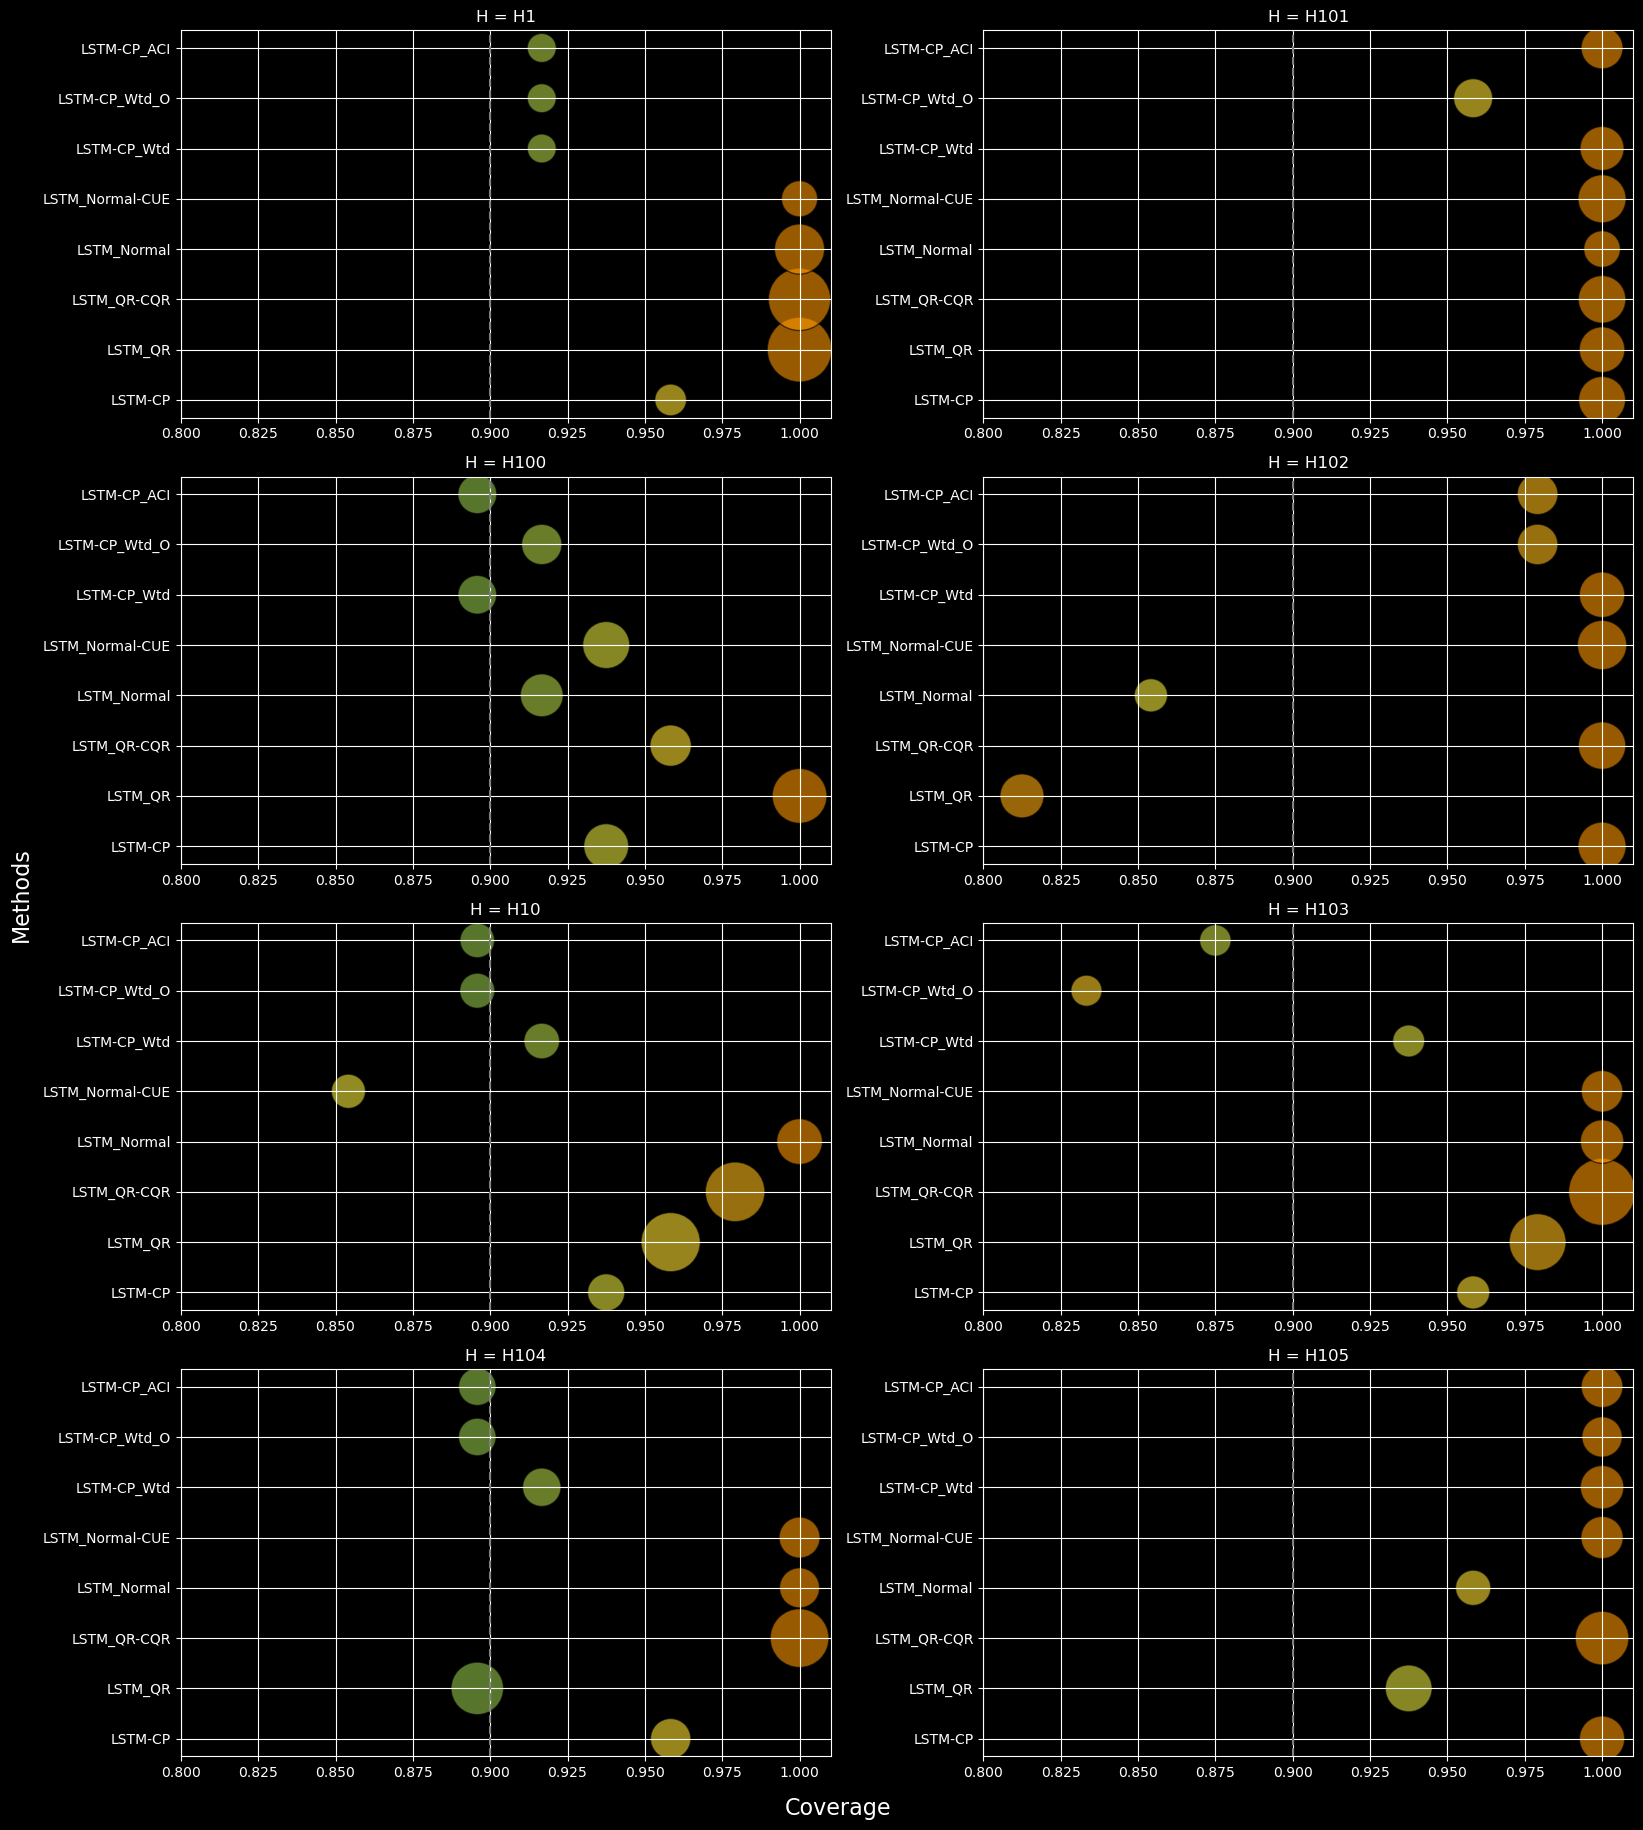

In [61]:

# Desired order of methods
method_order = ['LSTM-CP', 'LSTM_QR', 'LSTM_QR-CQR', 'LSTM_Normal', 'LSTM_Normal-CUE', 'LSTM-CP_Wtd', 'LSTM-CP_Wtd_O', 'LSTM-CP_ACI']

# Define the colormap using the same color scheme as before
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#8bc34a', '#ffeb3b', '#ff9800'])

# Melt the DataFrame to long format
df_long = pd.melt(res_df.reset_index(), id_vars='index', 
                  value_vars=[f'{method}_Cov' for method in ['LSTM-CP', 'LSTM_QR', 'LSTM_QR-CQR', 'LSTM_Normal', 'LSTM_Normal-CUE', 'LSTM-CP_Wtd', 'LSTM-CP_Wtd_O', 'LSTM-CP_ACI']] + 
                             [f'{method}_AvgL' for method in ['LSTM-CP', 'LSTM_QR', 'LSTM_QR-CQR', 'LSTM_Normal', 'LSTM_Normal-CUE', 'LSTM-CP_Wtd', 'LSTM-CP_Wtd_O', 'LSTM-CP_ACI']],
                  var_name='Metric', value_name='Value')

# Split the 'Metric' column into 'Method' and 'MetricType' (Cov or AvgL)
df_long[['Method', 'MetricType']] = df_long['Metric'].str.rsplit('_', n=1, expand=True)

# Pivot the DataFrame to have separate columns for Coverage and AvgLength
df_pivot = df_long.pivot_table(index=['index', 'Method'], columns='MetricType', values='Value').reset_index()

# Normalize the coverage and average length values for each H value
df_pivot['NormalizedCoverage'] = df_pivot.groupby('index')['Cov'].transform(lambda x: x/x.mean())
df_pivot['NormalizedAvgLength'] = df_pivot.groupby('index')['AvgL'].transform(lambda x: x/x.mean())

# Calculate the color based on the distance from 0.90 coverage
df_pivot['Color'] = df_pivot['Cov'].apply(lambda x: cmap(np.abs(x - 0.90) / 0.1))

df_pivot['Method'] = pd.Categorical(df_pivot['Method'], categories=method_order, ordered=True)

# Sort the dataframe by 'Method' to ensure the plotting order is correct
df_pivot = df_pivot.sort_values('Method')

# Identify unique H values
unique_ids = df_pivot['index'].unique()

# Determine the layout for subplots
n_rows = int(np.ceil(len(unique_ids) / 2))
fig, axes = plt.subplots(n_rows, 2, figsize=(18, 5 * n_rows))

# Flatten axes array for easy iteration if it's a 2D array
axes = axes.flatten()

unique_id_scale = {
    "H1": 1000,
    "H101": 1000,
    "H100": 1000,
    "H102": 1000,
    "H10": 1000,
    "H103": 1000,
    "H104": 1000,
    "H105": 1000,
}

# Plot each subplot
for i, unique_id in enumerate(unique_ids):
    ax = axes[i]
    df_subset = df_pivot[df_pivot['index'] == unique_id]

    scatter = ax.scatter(df_subset['Cov'], df_subset['Method'], 
                         s=df_subset['NormalizedAvgLength'] * unique_id_scale[unique_id], 
                         c=df_subset['Color'], 
                         alpha=0.6, edgecolor='black')
    
    ax.set_title(f'H = {unique_id}')
    ax.axvline(0.90, color='grey', linestyle='--')
    ax.grid(True)
    
    # Set y-limits to center around 0.90
    ax.set_xlim(0.8, 1.01)  # Adjust these limits as needed

# Add common labels and colorbar
fig.text(0.5, 0.04, 'Coverage', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Methods', va='center', rotation='vertical', fontsize=16)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()